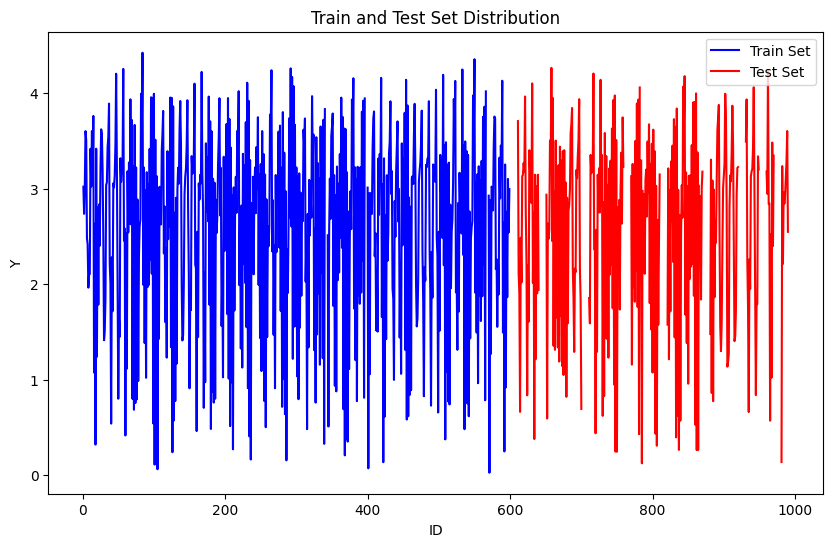

In [ ]:
# Just Observe the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
dataset_lookup = pd.read_csv('data.csv')
dataset_lookup['Y'] = pd.to_numeric(dataset_lookup['Y'], errors='coerce')
dataset_lookup['Y'].replace(999, np.nan, inplace=True)

# Assuming 'ID' is a column in your dataset_lookupframe
train_dataset_lookup = dataset_lookup[dataset_lookup['ID'] < 600]
test_dataset_lookup = dataset_lookup[dataset_lookup['ID'] >= 600]

plt.figure(figsize=(10, 6))

# Plotting train set in blue
plt.plot(train_dataset_lookup['ID'], train_dataset_lookup['Y'], color='blue', label='Train Set')

# Plotting test set in red
plt.plot(test_dataset_lookup['ID'], test_dataset_lookup['Y'], color='red', label='Test Set')


plt.title('Train and Test Set Distribution')
plt.xlabel('ID')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Configs
look_back = 5  # Define the look back period

# Load the data
data = pd.read_csv('data.csv')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')
data['Y'].replace(999, np.nan, inplace=True)

# Selecting training and testing data
train = data[data['ID'] <= 600].copy()
train = train.fillna(method='ffill')
train_data = train[train['ID'] <= 600]
test_data = data[(data['ID'] > 600) & (data['ID'] <= 1000)]

# test_data = test_data.fillna(method='ffill')

# Scaling the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_data[['Y']])
test_features = scaler.transform(test_data[['Y']])

# Function to create sequences with look_back
def create_dataset(dataset, look_back=1):
    m = len(dataset)
    X = []
    y = []
    for i in range(look_back, m):
        X.append(dataset[i - look_back: i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Convert to PyTorch tensors
X_train_sequences, Y_train_sequences = create_dataset(train_features, look_back)
X_test_sequences, Y_test_sequences   = create_dataset(test_features, look_back)

# Convert sequences and targets to PyTorch tensors
train_sequences_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
train_targets_tensor = torch.tensor(Y_train_sequences, dtype=torch.float32)
test_sequences_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
test_targets_tensor = torch.tensor(Y_test_sequences, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_sequences_tensor, train_targets_tensor)
test_dataset = TensorDataset(test_sequences_tensor, test_targets_tensor)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=look_back):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)  # Hidden layer to output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = MLP()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    for sequences, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

Epoch 0/100, Loss: 0.8117034435272217
Epoch 1/100, Loss: 0.3750719130039215
Epoch 2/100, Loss: 0.5207266807556152
Epoch 3/100, Loss: 0.34626445174217224
Epoch 4/100, Loss: 0.31729719042778015
Epoch 5/100, Loss: 0.2926349341869354
Epoch 6/100, Loss: 0.18088118731975555
Epoch 7/100, Loss: 0.8651223182678223
Epoch 8/100, Loss: 0.223025843501091
Epoch 9/100, Loss: 0.7417082786560059
Epoch 10/100, Loss: 0.3101784884929657
Epoch 11/100, Loss: 0.16184985637664795
Epoch 12/100, Loss: 0.7200538516044617
Epoch 13/100, Loss: 0.15975873172283173
Epoch 14/100, Loss: 0.11115490645170212
Epoch 15/100, Loss: 0.7530006766319275
Epoch 16/100, Loss: 0.13212621212005615
Epoch 17/100, Loss: 0.6979029774665833
Epoch 18/100, Loss: 0.11284006386995316
Epoch 19/100, Loss: 0.20130009949207306
Epoch 20/100, Loss: 0.6584450602531433
Epoch 21/100, Loss: 0.104920394718647
Epoch 22/100, Loss: 0.35861828923225403
Epoch 23/100, Loss: 0.13239090144634247
Epoch 24/100, Loss: 0.09848029166460037
Epoch 25/100, Loss: 0.569

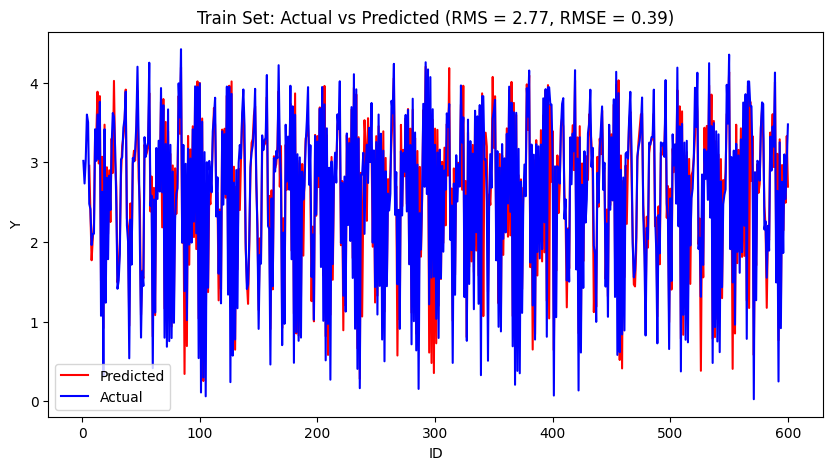

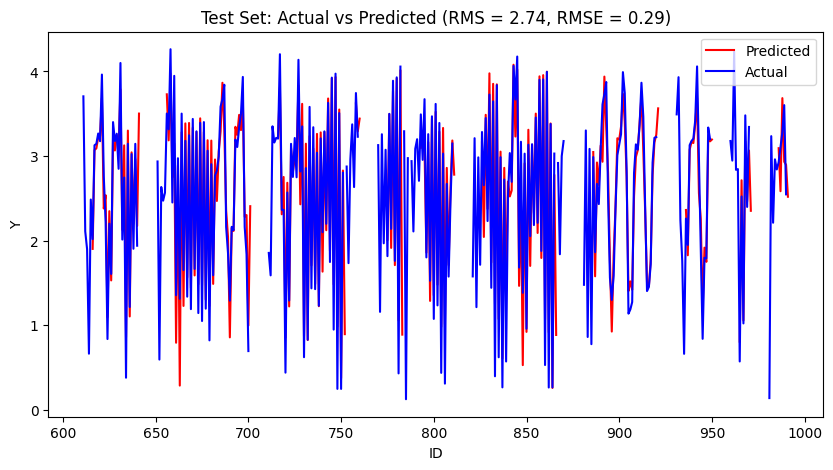

In [ ]:
# Obtain predictions for the train set
with torch.no_grad():
    train_predictions = model(train_sequences_tensor).squeeze().numpy()
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()

# Obtain predictions for the test set
with torch.no_grad():
    test_predictions = model(test_sequences_tensor).squeeze().numpy()
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Calculate RMS
train_rms = np.sqrt(np.mean(np.square(train_data['Y'].iloc[look_back:])))
test_rms = np.sqrt(np.mean(np.square(test_data['Y'].iloc[look_back:])))

# Calculate RMSE
train_rmse = np.sqrt(np.mean(np.square(train_predictions - train_data['Y'].iloc[look_back:])))
test_rmse = np.sqrt(np.mean(np.square(test_predictions - test_data['Y'].iloc[look_back:])))

# Plot actual vs predicted values for the test set
plt.figure(figsize=(10, 5))

# Plot actual vs predicted values for the train set
plt.plot(train_data['ID'].iloc[look_back:], train_predictions, label='Predicted', color='red')
plt.plot(train_data['ID'], train_data['Y'], label='Actual', color='blue')
plt.title('Train Set: Actual vs Predicted (RMS = {:.2f}, RMSE = {:.2f})'.format(train_rms, train_rmse))
plt.xlabel('ID')
plt.ylabel('Y')
plt.legend()
plt.show()

# Plot actual vs predicted values for the test set
plt.figure(figsize=(10, 5))
plt.plot(test_data['ID'].iloc[look_back:], test_predictions, label='Predicted', color='red')
plt.plot(test_data['ID'], test_data['Y'], label='Actual', color='blue')
plt.title('Test Set: Actual vs Predicted (RMS = {:.2f}, RMSE = {:.2f})'.format(test_rms, test_rmse))
plt.xlabel('ID')
plt.ylabel('Y')
plt.legend()
plt.show()

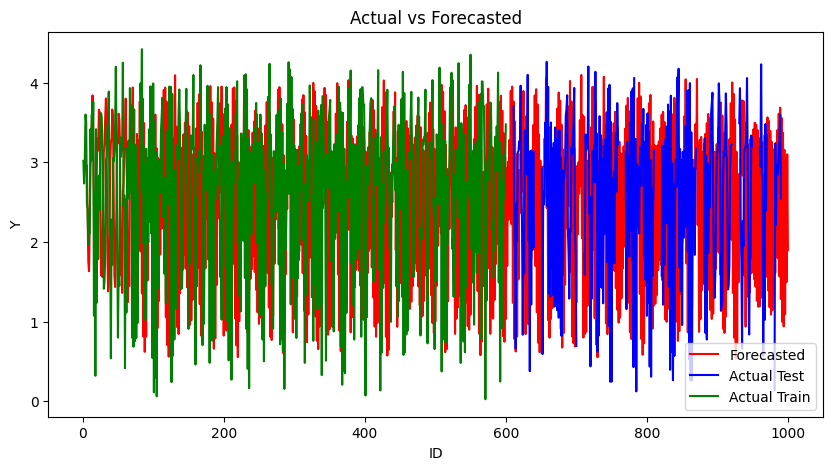

In [ ]:
# Full Auto-regressive
def autoregressive_forecast(model, start_sequence, num_predictions, scaler):
    model.eval()
    predictions = []
    current_sequence = start_sequence

    with torch.no_grad():
        for _ in range(num_predictions):
            current_tensor = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0)
            predicted_output = model(current_tensor).item()
            predictions.append(predicted_output)

            # Update the current sequence to include the new prediction
            current_sequence = np.append(current_sequence[1:], predicted_output)

    # Scale the predictions back to the original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions).flatten()

    return predictions

initial_sequence = train_sequences_tensor[0].numpy()
num_future_points = len(train_data) + len(test_data) - look_back
# Generate IDs that match the number of forecasted values
start_id = train_data['ID'].iloc[look_back]  # Starting ID from the end of look-back in training data
end_id = start_id + num_future_points - 1    # Ending ID based on number of predictions
forecast_ids = np.arange(start_id, end_id + 1)

forecasted_values = autoregressive_forecast(model, initial_sequence, num_future_points, scaler)

# Ensure that the number of forecasted IDs matches the number of forecasted values
assert len(forecast_ids) == len(forecasted_values), "Mismatch in length of forecast IDs and values"

plt.figure(figsize=(10, 5))
plt.plot(forecast_ids, forecasted_values, label='Forecasted', color='red')
plt.plot(test_data['ID'], test_data['Y'], label='Actual Test', color='blue')
plt.plot(train_data['ID'], train_data['Y'], label='Actual Train', color='green')

plt.title('Actual vs Forecasted')
plt.xlabel('ID')
plt.ylabel('Y')
plt.legend()
plt.show()

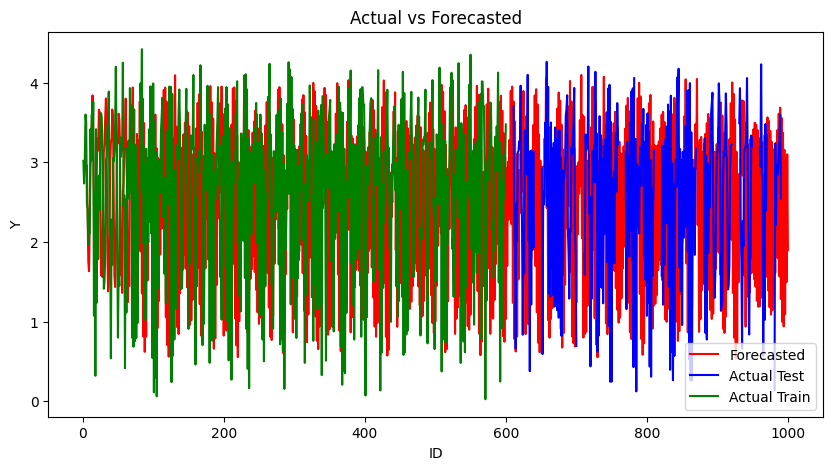

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming the definition of autoregressive_forecast is as provided earlier

initial_sequence = train_sequences_tensor[0].numpy()
num_future_points = len(train_data) + len(test_data) - look_back

# Generate IDs that match the number of forecasted values
start_id = train_data['ID'].iloc[look_back]  # Starting ID from the end of look-back in training data
end_id = start_id + num_future_points - 1    # Ending ID based on number of predictions
forecast_ids = np.arange(start_id, end_id + 1)

forecasted_values = autoregressive_forecast(model, initial_sequence, num_future_points, scaler)

# Ensure that the number of forecasted IDs matches the number of forecasted values
assert len(forecast_ids) == len(forecasted_values), "Mismatch in length of forecast IDs and values"

# Create a DataFrame from the forecasted IDs and values
forecast_df = pd.DataFrame({
    'ID': forecast_ids,
    'Forecasted_Y': forecasted_values
})

# Save the DataFrame to a CSV file
forecast_df.to_csv('forecasted_data.csv', index=False)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(forecast_ids, forecasted_values, label='Forecasted', color='red')
plt.plot(test_data['ID'], test_data['Y'], label='Actual Test', color='blue')
plt.plot(train_data['ID'], train_data['Y'], label='Actual Train', color='green')
plt.title('Actual vs Forecasted')
plt.xlabel('ID')
plt.ylabel('Y')
plt.legend()
plt.show()
